At the present moment, the dominant models for nearly all natural language processing tasks are based on the Transformer architecture. Given any new task in natural language processing, the default first-pass approach is to grab a large Transformer-based pretrained model, (e.g., BERT (Devlin et al., 2018), ELECTRA (Clark et al., 2020), RoBERTa (Liu et al., 2019), or Longformer (Beltagy et al., 2020)) adapting the output layers as necessary, and fine-tuning the model on the available data for the downstream task.

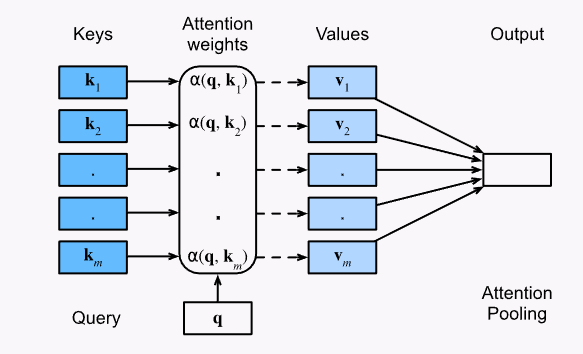

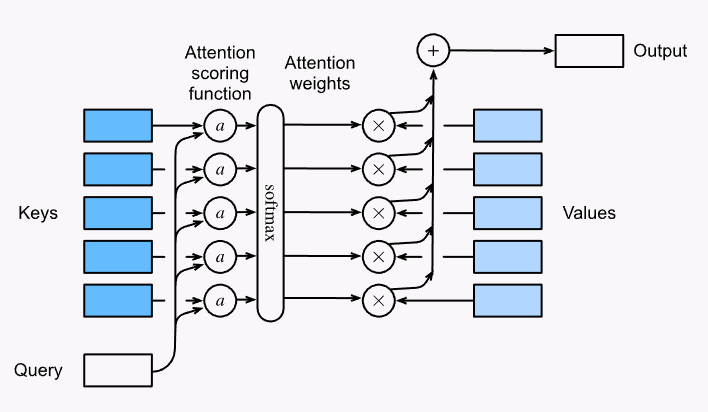

- Key: the dictionary input
- Value: the dictionary output
- Query: attention weight per key - a vector that describes the relationship of one token to by multiplying the previous encoder with the weight gradient. Essentially the future encoding vector

Querys and Keys are multiplied by dot product in one "head" to determine the relationship of tokens in relation to the head's query.

Multi-heads then contribute to many different query types to get the full spectrum of relationships. Querys and keys are initialized randomly, but during backpropogation the initialization for each head will result in convergence meaningful mathematically relationship. For example Head 1 converges on grammar-rhetoric while Head 2 converges on verb-rhetoric. If several heads converge to the same mathematical minimum, the model is less efficient overall naturally pushing each head to converge to other useful patterns.

The attention scoring function defines the relationship between Key and Query. This is most typically a dot-product, which is then fed into an activation + normalization function to squeeze the range between [0,1]

In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

In [13]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

In [14]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Valid_lens determines the rows of elements to masked in the last axis, manipulated the other randomly generated numbers to sum up to 1 properly

Ultimately reshapes the model tensors to only attend to valid past tokens

#### Scaled dot-product attention

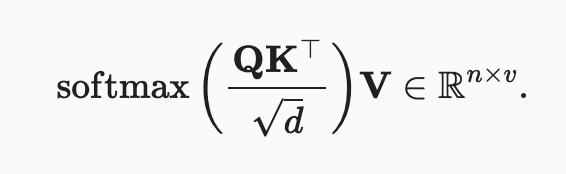

In [21]:
class DotProductAttention(nn.Module):
    """Scaled dot-product attention"""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [22]:
q = torch.normal(0, 1, (2, 1, 2))
k = torch.normal(0, 1, (2, 10, 2))
v = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(q, k, v, valid_lens), (2, 1, 4))

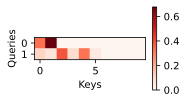

In [23]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In the heatgraph, the attention weights show to vanish beyond 1x2 and 2x6, which was defined in valid_lens

In [24]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [26]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, k, v, valid_lens), (2, 1, 4))

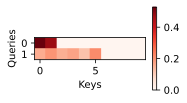

In [27]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

Similar heat graph for additive scoring, but with more of a uniform distribution. Additive scoring can all lea to some minor comutational savings